# CSCI 4314 Final Project

**Authors: Alvaro Carpio, Guillermo Munoz, Tom Stoughton**

In this noetbook, we implement the Generalized Integrate and Fire neuron simulation model and test different parameter values. Then, we attempt to model a chain of neurons sending an action potential around a circuit, which should produce a predictable cycle of voltage spikes from one neuron to the next.

In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt

### Helper Functions

This section of the code will be some helper functions that will make the implementation easier to read.

In [2]:
def plot_voltage(v, v_th, t_start, t_stop, dt):
    # Inputs :
    # v      : array of voltage values over time
    # v_th   : voltage threshold value
    # t_start: time to start plotting
    # t_stop : time to stop plotting
    # dt     : time step
    
    # Output: a plot of the voltage over time with spikes (action potentials) increased for visualization
    
    ts = np.arange(t_start, t_stop + dt, dt)
    
    # ensure ts and v have same dimensions
    if len(ts) != len(v):
        print(f"Cannot plot: ts is size {len(ts)}, v is size {len(v)}.")
        return
    plt.plot(ts, v)
    plt.title("Voltage over Time")
    
    # draw line at voltage threshold
    plt.axhline(v_th, 0, 1, color='k', ls='--')
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    # plt.legend()
    plt.show()
    
def plot_voltages(v, v_th, t_start, t_stop, dt):
    # Inputs :
    # v      : matrix of voltage values over time
    # v_th   : voltage threshold value
    # t_start: time to start plotting
    # t_stop : time to stop plotting
    # dt     : time step
    
    # Output: a plot of the voltage over time with spikes (action potentials) increased for visualization
    
    ts = np.arange(t_start, t_stop + dt, dt)
    
    n, m = np.shape(v)
    for i in range(n):
        
        # ensure ts and v have same dimensions
        if len(ts) != len(v[i]):
            print(f"Cannot plot: ts is size {len(ts)}, v is size {len(v)}.")
            return
        plt.plot(ts, v[i], label=f"Neuron {i+1}")


    

    
    # draw line at voltage threshold
    plt.axhline(v_th, 0, 1, color='k', ls='--')
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    plt.title("Voltage over Time")
    plt.legend()
    plt.show()
    

## Generalized Integrate and Fire

This code simulates the GIF model for a single neuron, generating an array of output voltage values and time values where spikes occured. 

Formulae: 

\begin{equation}
C_m\frac{dV}{dt} = -g_L(V-E_L) - \sum_{k}w_k + I
\end{equation}

where

\begin{equation}
\tau_k\frac{dw_k}{dt} = a_k(V - E_L) - w_k
\end{equation}

and

\begin{equation}
w_k(t+\Delta) = w_k + b_k 
\end{equation}

In [46]:
def GIF(I, v_init, v_th, v_reset, v_sp, C_m, g_L, E_L, tref, t_start, t_stop, dt, w, a, b, tau):
    # Inputs
    # I        : vector with values of current put into the system at each time step
    # v_init   : initial voltage of the system
    # v_th     : voltage threshold
    # v_reset  : voltage reset potential
    # v_sp     : the voltage increase when an action potential occurs
    # C_m      : membrane capacitance
    # g_L      : leak conductance
    # E_L      : leak reversal potential
    # tref     : refractory time
    # t_start  : time to start plotting
    # t_stop   : time to stop plotting
    # dt       : time step
    # w        : vector of inhibitory currents
    # a        : vector of sub-threshold coupling coefficients
    # b        : vector of spike-triggered jumps
    # tau      : vector of time scales
    
    # Outputs
    # v        : vector of voltages generated from simulation
    
    ts = np.arange(t_start, t_stop + dt, dt)
    
    # initialize v
    v = np.zeros(len(ts))
    v[0] = v_init
    
    ref_countdown = 0
    
    for t in range(len(ts) - 1):
        # are we in refractory period?
        spike = False
        if ref_countdown > 0:
            v[t] = E_L
            ref_countdown -= 1
        # is voltage over the threshold?
        elif v[t] > v_th:
            v[t] += v_sp
            t += 1
            v[t] = E_L
            ref_countdown = tref / dt
            spike = True
                
        w_sum = sum(w)
        
        # use Euler's integration method to update voltage
        dv = (dt / C_m) * (-g_L*(v[t] - E_L) - w_sum + I[t])
        v[t+1] = v[t] + dv
        
        # use Euler's integration method to update inhibitory currents
        
        # without this, the model is only Leaky Integrate and Fire (LIF)
        # need to find good values of w, a, b, and tau to get GIF
        for k in range(len(w)):
            dw = (dt / tau[k]) * (a[k]*(v[t] - E_L) - w[k])
            w[k] += dw
            if spike:
                w[k] += b[k]
    return v

In [47]:
# setup parameters for GIF run
t0 = 0
tf = 400
dt = 0.1

length = int((tf - t0)/dt)

# constant current input
# should continuously cause action potentials
I = 150*np.ones( length )

v0  = -70
vth = -65
vr  = v0-5
vsp = 10

C_m = 1000
g_L = 10
E_L = -75

tref = 20

# change to get GIF
channels = 2

w = 1*np.linspace(1, 2, channels)
a = 0*np.ones(channels)
b = 10*np.linspace(1, 2, channels)
tau = np.ones(channels)*dt


In [48]:
v = GIF(I, v0, vth, vr, vsp, C_m, g_L, E_L, tref, t0, tf, dt, w, a, b, tau)

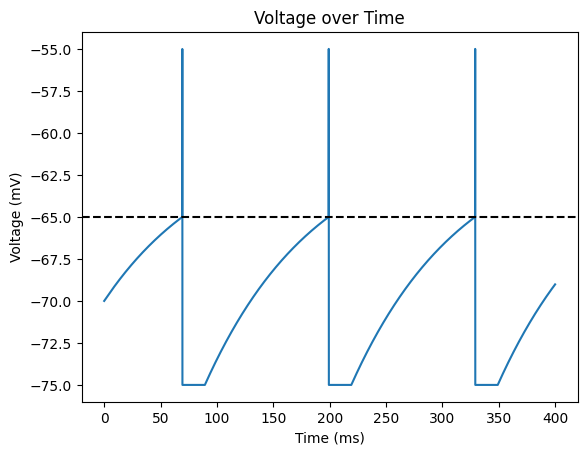

In [49]:
plot_voltage(v, vth, t0, tf, dt)

In [50]:
def GIF_many(n, I, v_init, v_th, v_reset, v_sp, r, C_m, g_L, E_L, t_c, tref, t_start, t_stop, dt, w, a, b, tau):
    # Inputs
    # n        : number of neurons to simulate
    # I        : vector with values of current put into the system FOR THE FIRST NEURON at each time step
    # v_init   : initial voltages of the system
    # v_th     : voltage threshold
    # v_reset  : voltage reset potential
    # v_sp     : the voltage increase when an action potential occurs
    # r        : resistance of neuron-to-neuron current flow  (I = v/r)
    # C_m      : membrane capacitance
    # g_L      : leak conductance
    # E_L      : leak reversal potential
    # t_c      : time for current to travel from one neuron to the next
    # tref     : refractory time
    # t_start  : time to start plotting
    # t_stop   : time to stop plotting
    # dt       : time step
    # w        : vector of inhibitory currents
    # a        : vector of sub-threshold coupling coefficients
    # b        : vector of spike-triggered jumps
    # tau      : vector of time scales
    
    # Outputs
    # v        : matrix of voltages generated from simulation
    
    ts = np.arange(t_start, t_stop + dt, dt)
    
    tc = int(t_c/dt)   # convert ms to indices
    
    # initialize vs
    v = np.zeros((n, len(ts)))
    for i in range(n):
        v[i][0] = v_init[i]
        
    # initialize current inputs
    current = np.zeros((n, len(I)))
    current[0] = I
    # print(current)
    
    ref_countdown = np.zeros(n)
    
    for t in range(len(ts) - 1):
        # go through each neuron in every time step
        for neur in range(n):
            # are we in refractory period?
            spike = False
            if ref_countdown[neur] > 0:
                v[neur][t] = v_reset
                ref_countdown[neur] -= 1
            # is voltage over the threshold?
            elif v[neur][t] > v_th:
                v[neur][t] += v_sp
                v[neur][t+1] = v_reset
                ref_countdown[neur] = tref / dt
                spike = True
                
                # update current for next neuron
                if neur < n-1:
                    current[neur+1] = current[neur]
                elif n != 1:
                    current[0] = current[neur]
                current[neur] = np.zeros(len(I))

            w_sum = sum(w)

            # use Euler's integration method to update voltage
            dv = (dt / C_m) * (-g_L*(v[neur][t] - E_L) - w_sum + current[neur][t])
            v[neur][t+1] = v[neur][t] + dv
            

            # use Euler's integration method to update inhibitory currents

            # without this, the model is only Leaky Integrate and Fire (LIF)
            # need to find good values of w, a, b, and tau to get GIF
            for k in range(len(w)):
                dw = (dt / tau[k]) * (a[k]*(v[neur][t] - E_L) - w[k])
                w[k] += dw
                if spike:
                    w[k] += b[k]
    return v, current

In [58]:
# setup parameters for multiple GIF run
n = 4
r = 0.07
tc = 15

t0 = 0
tf = 1000
dt = 0.1

length = int((tf - t0)/dt)

ap = 70

# current input
I = 150*np.ones( length )
# print(I)

v0  = -70*np.ones(n)
vth = -65
vr  = -75
vsp = 10

C_m = 1000
g_L = 10
E_L = -75

tref = 20

# change to get GIF
channels = 2

w = np.linspace(0, 1, channels)
a = np.ones(channels)
b = 2*np.linspace(1, 2, channels)
tau = np.ones(channels)*dt

In [59]:
v, c = GIF_many(n, I, v0, vth, vr, vsp, r, C_m, g_L, E_L, tc, tref, t0, tf, dt, w, a, b, tau)

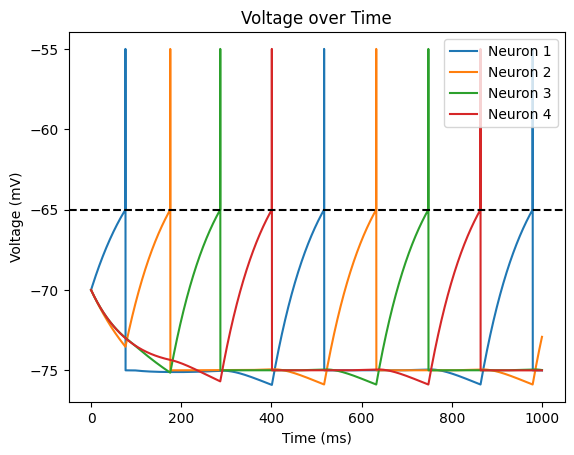

In [60]:
plot_voltages(v, vth, t0, tf, dt)